In [1]:
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os
import glob
from pathlib import Path
import seaborn as sns

kaplan_plots = True
cox_analysis = False

date_time_str = '20230621_233140'
data_path = Path(os.getcwd())

if kaplan_plots:
    kmf = KaplanMeierFitter()

    csv_files = glob.glob(os.path.join(data_path, f"outputs/{date_time_str}/*.csv"))

    if not os.path.exists(f"imgs/{date_time_str}"):
        os.makedirs(f"imgs/{date_time_str}")

    # Group runs by experiment
    grouped_files = {}
    for file in csv_files:
        file_name = os.path.basename(file)
        name_without_suffix = file_name.rsplit("-", 1)[0]
        suffix = file_name.rsplit("-", 1)[1]
        group_key = name_without_suffix

        if group_key not in grouped_files:
            grouped_files[group_key] = []

        grouped_files[group_key].append(file)


    kmfs = {}
    cphs = {}

    # Print the grouped file paths
    for group_key, files in grouped_files.items():
        fig = plt.figure()
        # For computing the mean
        surv_func_ci = pd.DataFrame()
        amt_of_runs = len(files)
        
        mean_survival_plots = pd.DataFrame(columns=list("TE"))
        CPH_data = pd.DataFrame()

        for i, file_path in enumerate(files):
            data_for_CPH = pd.read_csv(file_path)
            
            data_for_CPH_copy = data_for_CPH.copy()
            data_for_CPH_copy.loc[data_for_CPH_copy['T'] == 1000, 'E'] = 0 # post hoc fix if the last timestep is used as time of death
            
            datakf = data_for_CPH_copy[list('TE')]
            
            mean_survival_plots = pd.concat([mean_survival_plots, datakf])
            CPH_data = pd.concat([CPH_data, data_for_CPH_copy])

        kmf = KaplanMeierFitter(label=group_key)
        cphs[group_key] = CPH_data

        kmfs[group_key] = kmf.fit(mean_survival_plots["T"], mean_survival_plots['E']) # Deze line geeft die warnings, maar kon het niet oplossen nog
        kmf.plot(label='Mean')

        plt.suptitle("Kaplan-Meier survival graph", fontsize=18)
        plt.title(group_key, fontsize=10)
        plt.xlabel("Time steps")
        plt.ylabel("Survival probability")
        plt.legend()

        plt.savefig(f"imgs/{date_time_str}/km-{group_key}.png")
        plt.close()


    

In [12]:
# All combinations image A (for Appendix)
fig = plt.figure(figsize=(10, 10))

legend_ax = fig.add_subplot(111, frameon=False)
legend_ax.axis('off')

nr_agents = [50, 100] # [50, 100, 200, 300]
dists = ['Sides', 'Uniform', 'RandomGrid']
probs = [0.5, 0.8, 1]
i=0

for nr_agent in nr_agents:
    for dist in dists:
        for prob in probs:
            i+=1

            if i == 1:
                ax = plt.subplot(6, 3, i)
            else:
                ax = plt.subplot(6, 3, i, sharex=ax, sharey=ax)

            if dist == 'RandomGrid':
                dist_name = 'Random Blobs'
            else:
                dist_name = dist
            plt.title(f'{dist_name}, nr_agents = {nr_agent}, prob. = {prob}', fontsize=10)
            ax = kmfs[f'Baseline-no_trade-{dist}-{nr_agent}-{prob}'].plot(label='Non-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-random-{dist}-{nr_agent}-{prob}'].plot(label='Random-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-pathfind_neighbor-{dist}-{nr_agent}-{prob}'].plot(label='Neighbor-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Market-pathfind_market-{dist}-{nr_agent}-{prob}'].plot(label='Market-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 0.94), fontsize=12)
fig.tight_layout(rect=(0.03, 0.03, 1, 0.9))
plt.subplots_adjust(wspace=0.3)
fig.text(0.5, 0.03, 'Time steps', ha='center', va='center', fontsize=14)
fig.text(0.03,  0.5, 'Survival probability', ha='center', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Kaplan-Meier survival graphs (A)", fontsize=20, y=0.98)
plt.savefig(f"imgs/{date_time_str}/kms-comparison-market-uber-A.pdf")
plt.close()


# All combinations image B (for Appendix)
fig = plt.figure(figsize=(10, 10))

legend_ax = fig.add_subplot(111, frameon=False)
legend_ax.axis('off')

nr_agents = [200, 300] # [50, 100, 200, 300]
dists = ['Sides', 'Uniform', 'RandomGrid']
probs = [0.5, 0.8, 1]
i=0

for nr_agent in nr_agents:
    for dist in dists:
        for prob in probs:
            i+=1

            if i == 1:
                ax = plt.subplot(6, 3, i)
            else:
                ax = plt.subplot(6, 3, i, sharex=ax, sharey=ax)
            
            if dist == 'RandomGrid':
                dist_name = 'Random Blobs'
            else:
                dist_name = dist
            plt.title(f'{dist_name}, nr_agents = {nr_agent}, prob. = {prob}', fontsize=10)
            ax = kmfs[f'Baseline-no_trade-{dist}-{nr_agent}-{prob}'].plot(label='Non-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-random-{dist}-{nr_agent}-{prob}'].plot(label='Random-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-pathfind_neighbor-{dist}-{nr_agent}-{prob}'].plot(label='Neighbor-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Market-pathfind_market-{dist}-{nr_agent}-{prob}'].plot(label='Market-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 0.94), fontsize=12)
fig.tight_layout(rect=(0.03, 0.03, 1, 0.9))
plt.subplots_adjust(wspace=0.3)
fig.text(0.5, 0.03, 'Time steps', ha='center', va='center', fontsize=14)
fig.text(0.03,  0.5, 'Survival probability', ha='center', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Kaplan-Meier survival graphs (B)", fontsize=20, y=0.98)
plt.savefig(f"imgs/{date_time_str}/kms-comparison-market-uber-B.pdf")
plt.close()

C:\Users\guido\AppData\Local\Temp\ipykernel_8060\220188696.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i)
C:\Users\guido\AppData\Local\Temp\ipykernel_8060\220188696.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i)


# CPH for BLobs

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
         T    E  Trade_random  Trade_search  Trade_market
0   1000.0  0.0             0             0             0
1    537.0  1.0             0             0             0
2   1000.0  0.0             0             0             0
3    154.0  1.0             0             0             0
4   1000.0  0.0             0             0             0
..     ...  ...           ...           ...           ...
45  1000.0  0.0             0             0             1
46   211.0  1.0             0             0             1
47   195.0  1.0             0             0             1
48   881.0  1.0             0             0             1
49   224.0  1.0             0             0             1

[1000 rows x 5 columns]


<lifelines.CoxPHFitter: fitted with 1000 total observations, 436 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 564
   partial log-likelihood = -3647.26
         time fit was run = 2023-06-21 17:20:47 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.52       0.59       0.11            -0.75            -0.30                 0.47                 0.74
Trade_search   0.55       1.74       0.10             0.36             0.74                 1.44                 2.10
Trade_market   0.25       1.29       0.10             0.05             0.45                 1.05                 1.57

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -4.59 <0.005      17.82
Trade_search     0.00  5.72 <0.005      26.48
Trade_market     0.00  2.46   0.01       6.18
---
Concordance = 0.50
Partial AIC = 7300.52
log-likelihood ratio test = 94.11 on 3 df
-log2(p) of ll-ratio test = 64.92

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Trade_random -0.524543   0.591826  0.114156       -0.748284       -0.300801   
Trade_search  0.553327   1.739028  0.096744        0.363712        0.742941   
Trade_market  0.251600   1.286082  0.102181        0.051328        0.451872   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                  
Trade_random             0.473178             0.740225     0.0 -4.594970   
Trade_search             1.438660             2.102109     0.0  5.719506   
Trade_market             1.052668             1.571250     0.0  2.462289   

                         p   -log2(p)  
covariate                              
Trade_random  4.328112e-06  17.817831  
Trade_search  1.068345e-08  26.480048  
Trade_market  1.380532e-02   6.178632  


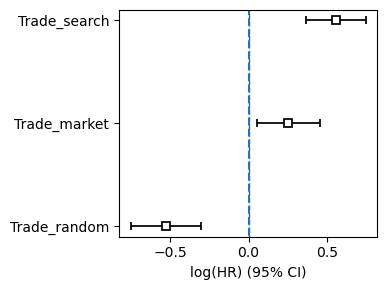

In [13]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs['Baseline-no_trade-RandomGrid-50-0.8'],
                             cphs['Baseline-random-RandomGrid-50-0.8'],
                             cphs['Baseline-pathfind_neighbor-RandomGrid-50-0.8'],
                             cphs['Market-pathfind_market-RandomGrid-50-0.8'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.show()

# CPH for Sides

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
        T    E  Trade_random  Trade_search  Trade_market
0   194.0  1.0             0             0             0
1   159.0  1.0             0             0             0
2   124.0  1.0             0             0             0
3   224.0  1.0             0             0             0
4   175.0  1.0             0             0             0
..    ...  ...           ...           ...           ...
45  150.0  1.0             0             0             1
46  212.0  1.0             0             0             1
47  122.0  1.0             0             0             1
48  270.0  1.0             0             0             1
49  126.0  1.0             0             0             1

[1000 rows x 5 columns]


<lifelines.CoxPHFitter: fitted with 1000 total observations, 1 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 999
   partial log-likelihood = -5876.74
         time fit was run = 2023-06-21 17:20:48 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.08       0.92       0.08            -0.24             0.08                 0.78                 1.08
Trade_search  -0.56       0.57       0.08            -0.72            -0.39                 0.49                 0.67
Trade_market   0.11       1.12       0.08            -0.05             0.28                 0.95                 1.32

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -1.03   0.30       1.72
Trade_search     0.00 -6.67 <0.005      35.17
Trade_market     0.00  1.40   0.16       2.63
---
Concordance = 0.50
Partial AIC = 11759.49
log-likelihood ratio test = 70.77 on 3 df
-log2(p) of ll-ratio test = 48.28

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Trade_random -0.084366   0.919095  0.081839       -0.244767        0.076035   
Trade_search -0.557821   0.572455  0.083646       -0.721764       -0.393877   
Trade_market  0.114753   1.121597  0.082061       -0.046084        0.275590   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                  
Trade_random             0.782887             1.079000     0.0 -1.030881   
Trade_search             0.485894             0.674437     0.0 -6.668813   
Trade_market             0.954962             1.317308     0.0  1.398387   

                         p   -log2(p)  
covariate                              
Trade_random  3.025965e-01   1.724533  
Trade_search  2.578814e-11  35.174501  
Trade_market  1.619969e-01   2.625962  


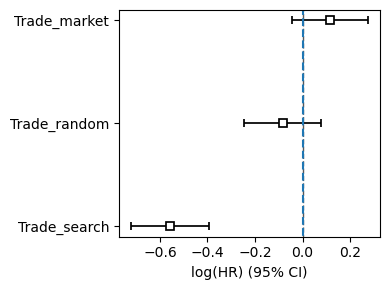

In [14]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Sides-50-1'],
                             cphs[f'Baseline-random-Sides-50-1'],
                             cphs[f'Baseline-pathfind_neighbor-Sides-50-1'],
                             cphs[f'Market-pathfind_market-Sides-50-1'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.show()

# CPH Sides threshold of significance market (varying nr agents)

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 1000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 1000
   partial log-likelihood = -5846.39
         time fit was run = 2023-06-21 17:20:49 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.01       0.99       0.08            -0.17             0.15                 0.84                 1.16
Trade_search  -0.81       0.44       0.09            -0.98            -0.64                 0.37                 0.53
Trade_market   0.06       1.07       0.08            -0.10             0.22                 0.91                 1.25

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -0.13   0.90       0.15
Trade_search     0.00 -9.26 <0.005      65.42
Trade_market     0.00  0.77   0.44       1.18
---
Concordance = 0.50
Partial AIC = 11698.79
log-likelihood ratio test = 131.47 on 3 df
-log2(p) of ll-ratio test = 91.63

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 2000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2000
number of events observed = 2000
   partial log-likelihood = -13152.73
         time fit was run = 2023-06-21 17:20:51 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.10       0.90       0.06            -0.22             0.01                 0.80                 1.01
Trade_search  -0.53       0.59       0.06            -0.65            -0.41                 0.52                 0.66
Trade_market   0.02       1.02       0.06            -0.09             0.13                 0.91                 1.14

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -1.79   0.07       3.78
Trade_search     0.00 -8.87 <0.005      60.23
Trade_market     0.00  0.36   0.72       0.48
---
Concordance = 0.50
Partial AIC = 26311.46
log-likelihood ratio test = 107.59 on 3 df
-log2(p) of ll-ratio test = 74.55

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 4000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4000
number of events observed = 4000
   partial log-likelihood = -29153.30
         time fit was run = 2023-06-21 17:20:55 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.08       0.93       0.04            -0.16             0.00                 0.86                 1.00
Trade_search  -0.26       0.77       0.04            -0.34            -0.17                 0.71                 0.84
Trade_market   0.04       1.04       0.04            -0.04             0.12                 0.96                 1.13

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -1.87   0.06       4.04
Trade_search     0.00 -6.19 <0.005      30.62
Trade_market     0.00  0.95   0.34       1.55
---
Concordance = 0.50
Partial AIC = 58312.61
log-likelihood ratio test = 55.92 on 3 df
-log2(p) of ll-ratio test = 37.74

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 6000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 6000
number of events observed = 6000
   partial log-likelihood = -46168.77
         time fit was run = 2023-06-21 17:21:00 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.15       0.86       0.03            -0.22            -0.09                 0.80                 0.92
Trade_search  -0.22       0.81       0.03            -0.28            -0.15                 0.75                 0.86
Trade_market   0.02       1.02       0.03            -0.05             0.09                 0.96                 1.09

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -4.58 <0.005      17.74
Trade_search     0.00 -6.50 <0.005      33.49
Trade_market     0.00  0.61   0.54       0.88
---
Concordance = 0.50
Partial AIC = 92343.54
log-likelihood ratio test = 67.18 on 3 df
-log2(p) of ll-ratio test = 45.73

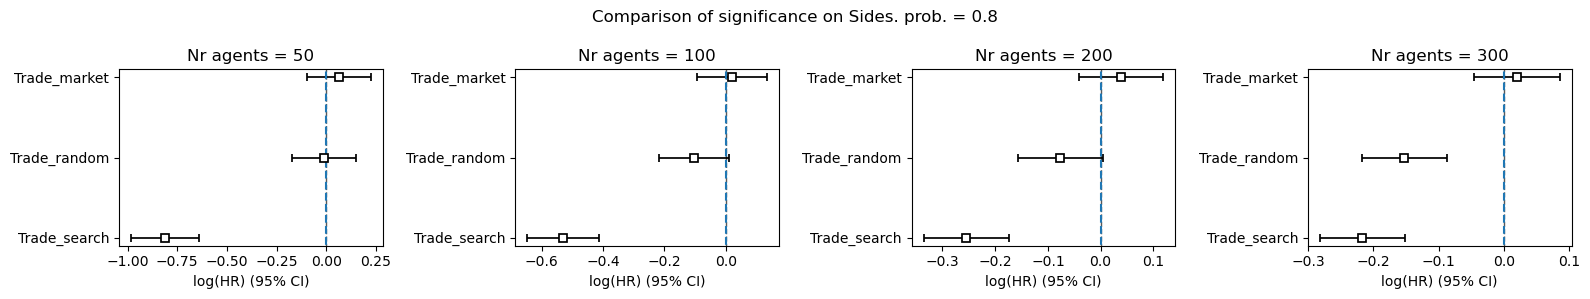

In [15]:
cox_analysis = True

nagentsss = [50, 100, 200, 300]

plt.figure(figsize=(16,3))

for i, n_agents in enumerate(nagentsss):
    if i > 0:
        ax = plt.subplot(1, 4, i+1, sharey=ax)
    else:
        ax = plt.subplot(1, 4, i+1)
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Sides-{n_agents}-0.8'],
                             cphs[f'Baseline-random-Sides-{n_agents}-0.8'],
                             cphs[f'Baseline-pathfind_neighbor-Sides-{n_agents}-0.8'],
                             cphs[f'Market-pathfind_market-Sides-{n_agents}-0.8'],
    ])
    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-{n_agents}-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-{n_agents}-results.csv")
    cph.print_summary()

    cph.plot()
    plt.title(f'Nr agents = {n_agents}')
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.suptitle('Comparison of significance on Sides. prob. = 0.8')
    
plt.show()

# CPH for Uniform

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
          T    E  Trade_random  Trade_search  Trade_market
0     317.0  1.0             0             0             0
1     338.0  1.0             0             0             0
2    1000.0  0.0             0             0             0
3     307.0  1.0             0             0             0
4     306.0  1.0             0             0             0
..      ...  ...           ...           ...           ...
295   319.0  1.0             0             0             1
296   243.0  1.0             0             0             1
297   490.0  1.0             0             0             1
298   316.0  1.0             0             0             1
299   323.0  1.0             0             0             1

[6000 rows x 5 columns]

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping 

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 6000 total observations, 1079 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic    p  -log2(p)
Trade_market km              5.71 0.02      5.89
             rank            4.64 0.03      5.00
Trade_random km              0.02 0.89      0.16
             rank            0.04 0.85      0.24
Trade_search km              0.09 0.76      0.39
             rank            0.20 0.65      0.62



1. Variable 'Trade_market' failed the non-proportional test: p-value is 0.0168.

   Advice: with so few unique values (only 2), you can include `strata=['Trade_market', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



<lifelines.CoxPHFitter: fitted with 6000 total observations, 1079 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 6000
number of events observed = 4921
   partial log-likelihood = -39741.01
         time fit was run = 2023-06-21 17:21:06 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random   0.00       1.00       0.04            -0.07             0.07                 0.94                 1.08
Trade_search   0.01       1.01       0.04            -0.06             0.08                 0.94                 1.08
Trade_market  -0.02       0.98       0.04            -0.09             0.05                 0.91                 1.05

               cmp to     z    p   -log2(p)
covariate                                  
Trade_random     0.00  0.13 0.90       0.15
Trade_search     0.00  0.24 0.81       0.30
Trade_market     0.00 -0.67 0.51       0.98
---
Concordance = 0.50
Partial AIC = 79488.01
log-likelihood ratio test = 0.86 on 3 df
-log2(p) of ll-ratio test = 0.26

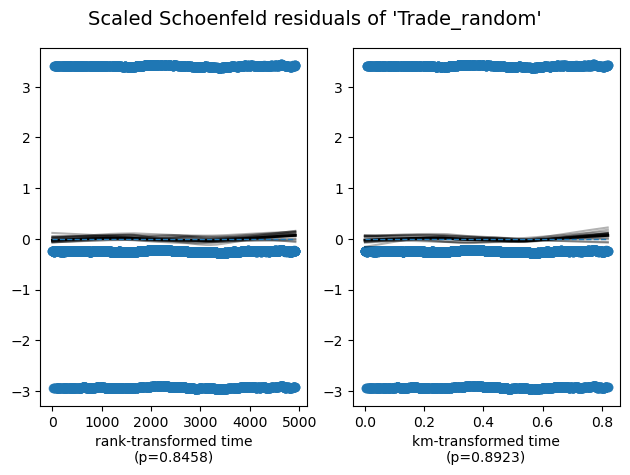

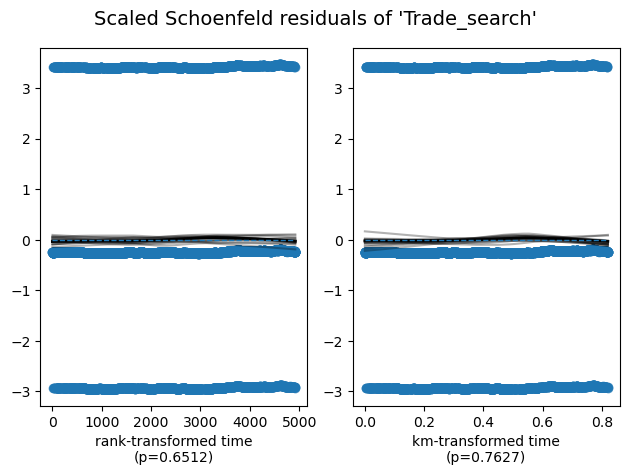

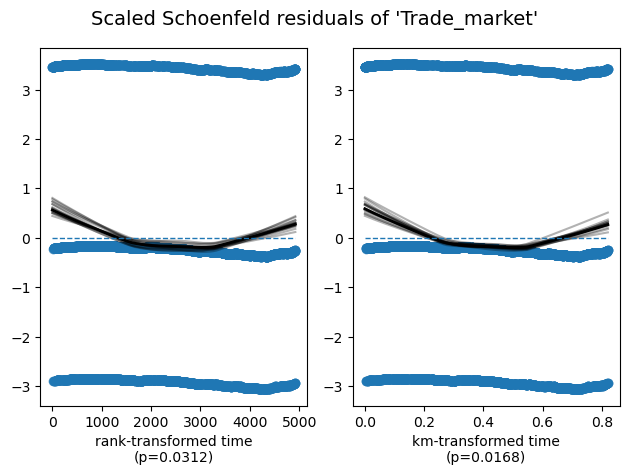

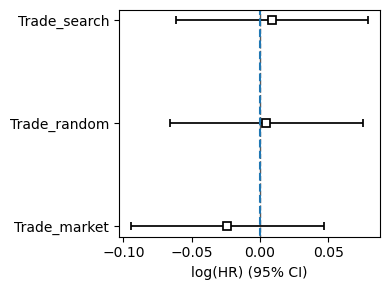

In [16]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Uniform-300-0.8'],
                             cphs[f'Baseline-random-Uniform-300-0.8'],
                             cphs[f'Baseline-pathfind_neighbor-Uniform-300-0.8'],
                             cphs[f'Market-pathfind_market-Uniform-300-0.8'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)


    cph.print_summary()
    cph_df = cph.summary
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.show()

# CPH for all data

In [17]:
cox_analysis = True

if cox_analysis:
    # Analysis
    def concatAllRuns(data_path: Path):
        csv_files = glob.glob(os.path.join(data_path, f"outputs/{date_time_str}/*.csv"))
        combined_df = pd.concat([pd.read_csv(f) for f in csv_files])
        return combined_df
    
    date_time_str = '20230619_192815'
    data_path = Path(os.getcwd())
    combined_df = concatAllRuns(data_path)
    print(combined_df)
    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df.tail())
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-results-all.csv")

         T    E  Scenario       Agent_type Distribution  Num_agents  Trading  \
0    242.0  1.0  Baseline         no_trade   RandomGrid         100     True   
1   1000.0  1.0  Baseline         no_trade   RandomGrid         100     True   
2    577.0  1.0  Baseline         no_trade   RandomGrid         100     True   
3   1000.0  1.0  Baseline         no_trade   RandomGrid         100     True   
4    137.0  1.0  Baseline         no_trade   RandomGrid         100     True   
..     ...  ...       ...              ...          ...         ...      ...   
45  1000.0  1.0    Market  pathfind_market      Uniform          50     True   
46  1000.0  1.0    Market  pathfind_market      Uniform          50     True   
47  1000.0  1.0    Market  pathfind_market      Uniform          50     True   
48  1000.0  1.0    Market  pathfind_market      Uniform          50     True   
49  1000.0  1.0    Market  pathfind_market      Uniform          50     True   

    Move_prob  Run_number  
0         0

<lifelines.CoxPHFitter: fitted with 117000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 117000
number of events observed = 117000
   partial log-likelihood = -1235196.19
         time fit was run = 2023-06-21 17:25:31 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Distribution  -0.42       0.66       0.00            -0.43            -0.41                 0.65                 0.66
Num_agents     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Move_prob     -0.39       0.68       0.01            -0.41            -0.36                 0.66                 0.70
Trade_random  -0.16       0.85       0.01            -0.18            -0.15                 0.84                 0.86
Trade_search   0.18       1.20       0.01             0.17             0.20                 1.18                 1.22
Trade_market   0.10       1.10       0.01             0.08             0.11                 1.09                 1.12

               cmp to       z      p   -log2(p)
covariate                                      
Distribution     0.00 -133.24 <0.005        inf
Num_agents       0.00   96.76 <0.005        inf
Move_prob        0.00  -28.33 <0.005     584.25
Trade_random     0.00  -21.73 <0.005     345.33
Trade_search     0.00   24.25 <0.005     429.07
Trade_market     0.00   13.21 <0.005     129.90
---
Concordance = 0.50
Partial AIC = 2470404.37
log-likelihood ratio test = 26384.57 on 6 df
-log2(p) of ll-ratio test = inf

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Distribution -0.419458   0.657403  0.003148       -0.425628       -0.413288   
Num_agents    0.003215   1.003220  0.000033        0.003150        0.003280   
Move_prob    -0.387728   0.678597  0.013684       -0.414549       -0.360908   
Trade_random -0.162668   0.849873  0.007486       -0.177341       -0.147995   
Trade_search  0.183266   1.201134  0.007558        0.168453        0.198079   
Trade_market  0.099538   1.104661  0.007536        0.084767        0.114309   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to           z  \
covariate                                                                    
Distribution             0.653359             0.661472     0.0 -133.238206   
Num_agents               1.003155             1.003286     0.0   96.759996   
Move_prob                0.660638   

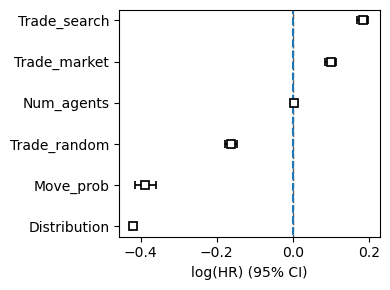

In [18]:
plt.figure(figsize=(4, 3))
cph.plot()
plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
plt.tight_layout()
plt.show()